# Web Scraping Financial Data

<br></br>
This project will allow us to get a bird's eye view of the S&P 500. We will web-scrape PE ratios from every stock on the S&P 500,  then graph the distribution by sector to see which sectors are comparitively undervalued. 



In [61]:
import pandas as pd
from bs4 import BeautifulSoup 
import urllib.request as ur
import pandas as pd
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", rc={"axes.facecolor": (0,0,0,0)})
import numpy as np
import time 

In [324]:
from urllib.error import HTTPError

# Read in Symbols and Sectors

In [2]:
#grab stocks and sector from https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
stocks = pd.read_csv('stocks.csv')
stocks.head()

,Symbol,Security,SEC filings,sector,GICS Sub Industry,CIK
0,ATVI,Activision Blizzard,reports,Communication Services,Interactive Home Entertainment,718877.0
1,GOOGL,Alphabet Inc Class A,reports,Communication Services,Interactive Media & Services,1652044.0
2,GOOG,Alphabet Inc Class C,reports,Communication Services,Interactive Media & Services,1652044.0
3,T,AT&T Inc.,reports,Communication Services,Integrated Telecommunication Services,732717.0
4,CTL,CenturyLink Inc,reports,Communication Services,Alternative Carriers,18926.0


In [3]:
stocks.columns

Index(['Symbol', 'Security', 'SEC filings', 'sector', 'GICS Sub Industry',
       'CIK'],
      dtype='object')

In [4]:
sectors = stocks['sector'].value_counts().head(11)
sectors

Industrials               72
Information Technology    71
Financials                66
Consumer Discretionary    63
Health Care               60
Consumer Staples          33
Real Estate               31
Utilities                 28
Materials                 28
Energy                    27
Communication Services    26
Name: sector, dtype: int64

In [5]:
sectors = sectors.index
sectors

Index(['Industrials', 'Information Technology', 'Financials',
       'Consumer Discretionary', 'Health Care', 'Consumer Staples',
       'Real Estate', 'Utilities', 'Materials', 'Energy',
       'Communication Services'],
      dtype='object')

In [9]:
stocks = stocks[stocks['sector'].isin(sectors)]

In [12]:
sectorList = list(stocks['sector'])
symbolList = list(stocks['Symbol'])

# Scrape PE Ratio for Every Stock Symbol

In [73]:
def outputPE(symbol):
    #create url 
    myurl = 'https://finance.yahoo.com/quote/'+symbol +'/key-statistics'
    #read in hml 
    read_data = ur.urlopen(myurl).read()
    soup = BeautifulSoup(read_data, 'lxml')
    #find table node element with financial information 
    data=[]
    table = soup.find('table')
    table_body = table.find("tbody")
    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])
        #return table element containing PE ratio
        
    return data[2][1]

In [327]:
from urllib.error import HTTPError

In [328]:
PEList = []
while (len(PEList)<len(symbolList)):
    #webscrape every stock symbol
    #if the server kicks you off, wait 5 seconds, then pickup where you left off
    for stock in symbolList[len(PEList)]:
        try:
            PEList.append(outputPE(stock))
        except HTTPError as err:
            if err.code == 503:
                time.sleep(5)

In [ ]:
# for ind, value in enumerate(PEList):
#     print(ind, value)

In [344]:
def findFirstInstance(array):
    for ind, val in enumerate(array):
        if (val=='-1.96%'):
            return ind

In [345]:
findFirstInstance(PEList)

106

In [347]:
while (len(PEList)<len(symbolList)):
    #webscrape every stock symbol
    #if the server kicks you off, wait 5 seconds, then pickup where you left off
    for stock in symbolList[len(PEList)]:
        try:
            PEList.append(outputPE(stock))
        except HTTPError as err:
            if err.code == 503:
                time.sleep(5)

In [ ]:
PEList = PEList[:findFirstInstance(PEList)]

try again until we get every stock we're looking for

In [350]:
while (len(PEList)<len(symbolList)):
    for stock in symbolList[len(PEList)]:
        try:
            PEList.append(outputPE(stock))
        except HTTPError as err:
            if err.code == 503:
                time.sleep(5)

In [417]:
PEList = PEList[:findFirstInstance(PEList)]

retrieved full list

In [355]:
len(PEList)

505

In [356]:
len(symbolList)

505

# Create DataFrame 

In [357]:
df = pd.DataFrame(np.arange(len(symbolList)))
df.columns = ["Sector"]
df["Sector"] = sectorList
df["Ratio"] = PEList
df["Symbol"] = symbolList 
df.head(10)

,Sector,Ratio,Symbol
0,Communication Services,36.19,ATVI
1,Communication Services,28.34,GOOGL
2,Communication Services,28.33,GOOG
3,Communication Services,14.99,T
4,Communication Services,8.35,CTL
5,Communication Services,62.84,CHTR
6,Communication Services,14.50,CMCSA
7,Communication Services,7.08,DISCA
8,Communication Services,6.51,DISCK
9,Communication Services,12.37,DISH


# Remove Missing Values

In [358]:
len(df)/len(df[df['Ratio']=='N/A'])

16.833333333333332

In [359]:
df = df[df['Ratio']!='N/A']

In [360]:
for ind, val in enumerate(list(df['Ratio'])):
    g= val
    if("k" in g):
        print(ind, val)

380 1.13k


In [361]:
df.iloc[380,1] = 1130

In [362]:
nums =[]
for i in list(df['Ratio']):
    nums.append(float(i))

In [363]:
df['Ratio'] = nums

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


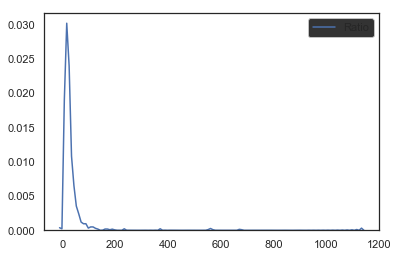

In [364]:
sns.kdeplot(df['Ratio'])

# Visualize

In [365]:
df['Log_PE_Ratio'] = np.log(df['Ratio'])

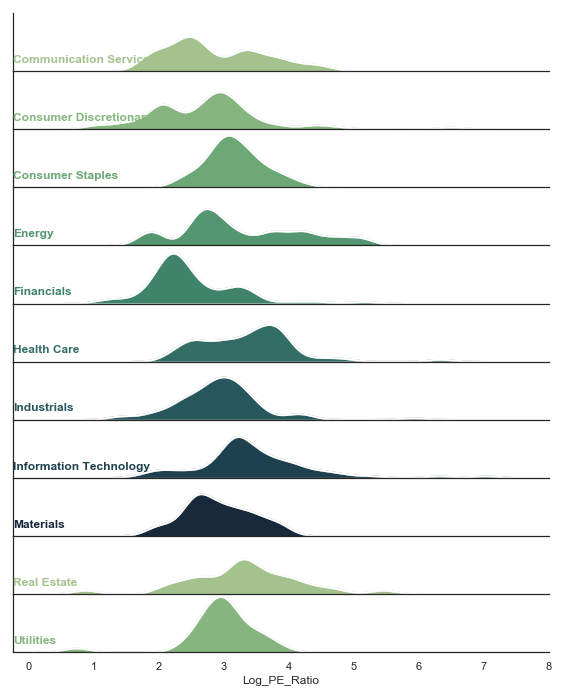

In [419]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(9, rot=-.60, light=.7)
g = sns.FacetGrid(df, row="Sector", hue="Sector", aspect=9, height=0.9, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'Log_PE_Ratio', clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, 'Log_PE_Ratio', clip_on=False, color="w", lw=2, bw=.2)

def label(Ratio, color, label):
    ax = plt.pyplot.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, 'Log_PE_Ratio')

# Set the subplots to nearly overlap
g.fig.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])


Its easy to see which sectors are comparitively undervalued. We can also see which sectors have a flatter distribution of valuations

# Find Most Undervalued Companies by Sector

In [372]:
df['Sector'].value_counts()

Industrials               70
Information Technology    69
Financials                65
Consumer Discretionary    63
Health Care               57
Real Estate               31
Consumer Staples          30
Utilities                 28
Communication Services    23
Materials                 23
Energy                    16
Name: Sector, dtype: int64

In [374]:
sectors

Index(['Industrials', 'Information Technology', 'Financials',
       'Consumer Discretionary', 'Health Care', 'Consumer Staples',
       'Real Estate', 'Utilities', 'Materials', 'Energy',
       'Communication Services'],
      dtype='object')

In [411]:
result = pd.DataFrame(columns = ['Sector','Symbols'])
result

,Sector,Symbols


In [412]:
for sector in sectors:
    temp = df[df['Sector']==sector].sort_values(by='Ratio').head(5)
    bestPerforming = list(temp['Symbol'])
    result = result.append({'Sector': sector, 'Symbols':bestPerforming}, ignore_index=True)

In [413]:
result

,Sector,Symbols
0,Industrials,"[DAL, AAL, UAL, ALK, URI]"
1,Information Technology,"[ADS, XRX, HPQ, STX, WU]"
2,Financials,"[UNM, MET, SYF, AIG, C]"
3,Consumer Discretionary,"[NCLH, MGM, KSS, RCL, CCL]"
4,Health Care,"[ALGN, ALXN, BIIB, CVS, HSIC]"
5,Consumer Staples,"[WBA, TSN, ADM, PM, KR]"
6,Real Estate,"[VNO, SPG, HST, CBRE, SLG]"
7,Utilities,"[NRG, PPL, EXC, CNP, ETR]"
8,Materials,"[LYB, WRK, EMN, CF, ALB]"
9,Energy,"[MPC, HFC, MRO, COP, EOG]"


There you have it ! The lowest 5 stocks by sector 